In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩 명령입니다.
    %tensorflow_version 2.x
except Exception:
    pass

# 이 노트북은 텐서플로 ≥2.4이 필요합니다
# 2.x 버전은 대부분 동일한 결과를 만들지만 몇 가지 버그가 있습니다.
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

input_shape = X_train.shape[1:]

### 12.3.5 사용자 정의 층

- 텐서플로에 없는 특이한 층을 가진 네트워크를 만들어야 할 때, 사용자 정의 층 만듬
- 반복되는 층을 하나의 층으로 다루기.
- Flatten이나 ReLU등의 가중치가 없는 층을 Lambda로 감싸기
- 감싼 층을 다른 보통의 층 처럼 사용할 수 있으며 또는 활성화 함수로 사용할 수 있다.
- 가중치를 가진 층을 만들려면 Layer를 상속해야 한다.

In [3]:
# 입력에 지수함수를 적용하는 층
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

In [4]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 1s 773us/step - loss: 1.0631 - val_loss: 0.4457
Epoch 2/5
363/363 [==============================] - 0s 529us/step - loss: 0.4562 - val_loss: 0.3798
Epoch 3/5
363/363 [==============================] - 0s 499us/step - loss: 0.4029 - val_loss: 0.3548
Epoch 4/5
363/363 [==============================] - 0s 490us/step - loss: 0.3851 - val_loss: 0.3464
Epoch 5/5
162/162 [==============================] - 0s 345us/step - loss: 0.3586


0.3586341142654419

In [6]:
# Dense 층의 간소화 버전을 구현한 것.
class MyDense(keras.layers.Layer):
    # 모든 하이퍼파라미터를 매개변수로 받는다.
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        
    # 가중치마다 add_weight를 호출하여 층의 변수를 만드는 것.
    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end
        # 이게 있어야 층이 만들어 졌다는 것을 케라스가 인식한다.

    def call(self, X): # 이 층의 출력
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape): # 이 층의 출력크기 반환
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self): # Serialize를 사용하여 전체 설정을 저장
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

- 여러가지 입력을 받는 층을 만들려면 call()에 모든 입력이 포함된 튜플을 매개변수로 전달해야한다.
- compute_output_shape도 마찬가지다.
- 여러가지 출력을 가진 층을 만들려면 call()이 출력의 리스트를 반환해야한다.
- compute_output_shape는 출력마다 하나씩 배치 출력크기의 리스트를 반환해야 한다.
- 함수형API와 서브클래싱 API에만 사용할수 있다.
- 1입력, 1출력이어야 하는 시퀀셜 API는 불가

In [7]:
# 두개의 입력과 세개의 출력
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape) # 사용자 정의 층 디버깅
        return [X1 + X2, X1 * X2, X1 / X2]

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2, batch_input_shape3 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2, batch_input_shape3]

- 훈련과 테스트에서 따로 동작하게 하려면 call() 메서드에 training 매개변수 추가

In [8]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training: # 훈련이라면 가우시안잡음 추가
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [9]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    AddGaussianNoise(stddev=1.0),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1)
])

In [10]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 751us/step - loss: 2.3857 - val_loss: 7.6082
Epoch 2/2
162/162 [==============================] - 0s 345us/step - loss: 0.7560


0.7559615969657898

### 12.3.6 사용자 정의 모델
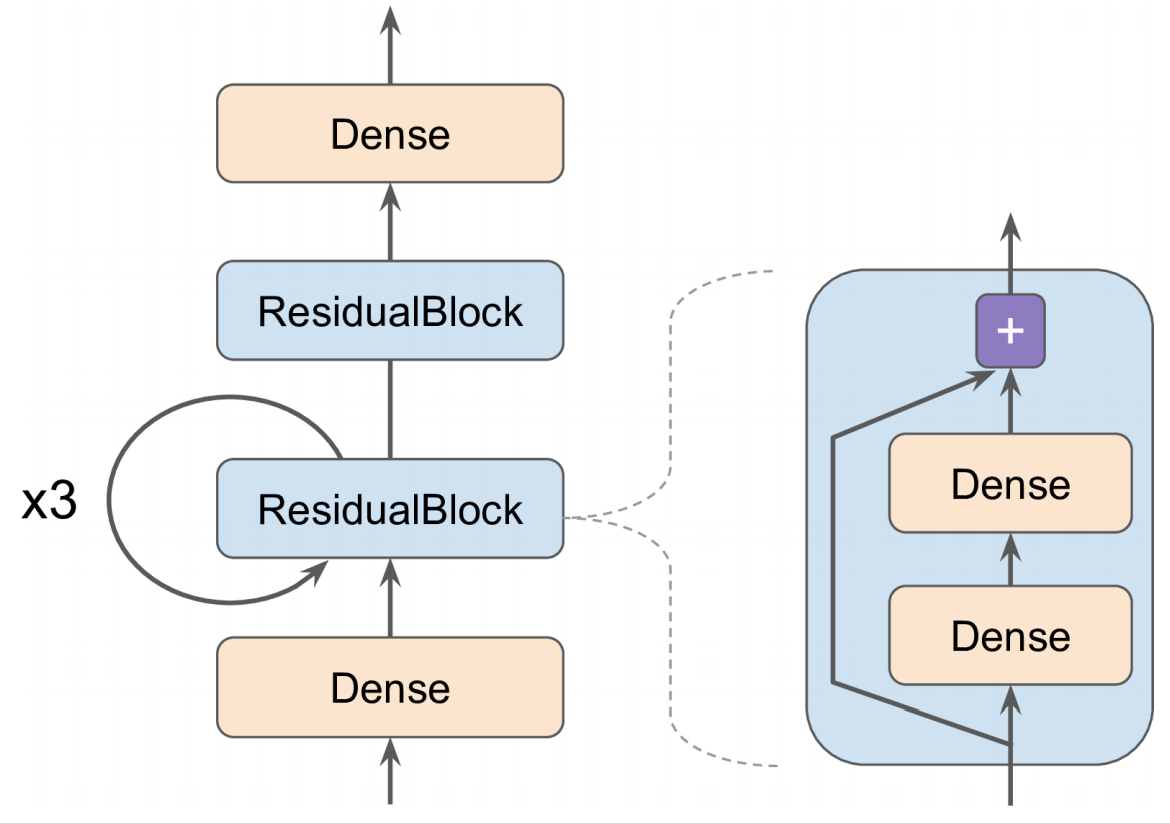
- 스킵 연결이 있는 사용자 정의 잔차 블록층을 가진 모델
- 두개의 완전연결층과 스킵연결로 구성된 잔차블록
- 실제 사용되는 모델이 아니라 예시를 보여주기 위한 모델

In [11]:
X_new_scaled = X_test_scaled

class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z
    
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [12]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 1s 915us/step - loss: 9.1325
Epoch 2/5
363/363 [==============================] - 0s 758us/step - loss: 1.0577
Epoch 3/5
363/363 [==============================] - 0s 965us/step - loss: 0.8866 0s - loss: 1
Epoch 4/5
363/363 [==============================] - 0s 896us/step - loss: 0.5837
Epoch 5/5
162/162 [==============================] - 0s 482us/step - loss: 0.6490


### 12.3.7 모델 구성 요소에 기반한 손실과 지표
- 규제나 모델의 내부 상황을 모니터링할 때 유용한 손실.
- 모델 구성 요소에 기반한 손실을 정의하고 계산한 결과를 add_loss() 메서드에 전달하게 함
- 예시 : 다섯개의 은닉층과 출력층으로 구성된 MLP 모델
    - 맨 위의 은닉층에 보조출력을 가진다.
    - 이 보조 출력에 연결된 손실을 재구성 손실이라고 부른다.(재구성과 입력 사이의 평균제곱오차)
    - 회귀작업에 직접 도움이 되지않더라도 모델이 은닉층을 통과하며 가능한 많은 정보를 유지하도록 유도함

In [17]:
# build() 메서드 대신 생성자에 reconstruct 층을 만듭니다
# 이 때문에 이 층의 유닛 개수를 하드코딩해야 합니다(또는 생성자 매개변수로 전달해야 합니다).
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruct = keras.layers.Dense(8) # TF 이슈 #46858에 대한 대책
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

#     TF 이슈 #46858 때문에 주석 처리
#     def build(self, batch_input_shape):
#         n_inputs = batch_input_shape[-1]
#         self.reconstruct = keras.layers.Dense(n_inputs, name='recon')
#         super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        self.recon_loss = 0.05 * tf.reduce_mean(tf.square(reconstruction - inputs))
        
        if training:
           result = self.reconstruction_mean(recon_loss)
           self.add_metric(result)
        return self.out(Z)
    
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred, regularization_losses=[self.recon_loss])

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {m.name: m.result() for m in self.metrics}

In [15]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
# 매 훈현마다 reconstruction_error가 계산되어 같이 출력된다!

model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2
363/363 [==============================] - 1s 784us/step - loss: 0.7885 - reconstruction_error: 0.0000e+00
Epoch 2/2
363/363 [==============================] - 0s 824us/step - loss: 0.4126 - reconstruction_error: 0.0000e+00


### 12.3.8 자동미분을 사용하여 그레이디언트 계산
- 밑의 식은 w1에 대한, w2에 대한 도함수 계산이 쉬움
- 신경망은 파라미터가 수만개이므로 직접 계산하기 힘듬
- 파라미터가 얼만큼 바뀌는지 측정하여 도함수의 근삿값을 계산하기.

In [24]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [25]:
# w1에 대한 도함수 계산하기

w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [26]:
# w2에 대한 도함수
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

- 이 방식은 근삿값일 뿐이고 파라미터마다 함수 f의 호출이 진행됨
- tf에는 자동미분이 있다.

In [28]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2]) # 이게 호출되는 순간 테이프가 날아가므로 tape.gradient()를 다시 불러올 수없음.
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [29]:
# 이렇게 Tape를 선언하면 테이프가 날아가지 않고 유지된다.
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape

- softmax 함수의 그레이디언트는 Nan이 나온다.
- 이는 부동소수점 정밀도 오류로 무한 나누기 무한이 된 것.
- 이는 해석적으로 softplus의 도함수를 구하는 방식으로 해결한다.

In [30]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

### 12.3.9 사용자 정의 훈련 반복
- fit() 메서드의 유연성이 충분하지 않을 때..? 사용한다.
- 엥간하면 fit을 쓰는 편이 좋다.

In [34]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [35]:
# 간단한 모델 생성
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

# 훈련 세트에서 샘플 배치를 랜덤하게 추출해주는 함수
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

# 훈련상태 표시 함수
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [36]:
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


In [38]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [39]:
mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


In [40]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

C:\Users\idjoo\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/5
11610/11610 [==============================] - mean: 1.3955 - mean_absolute_error: 0.5722
Epoch 2/5
11610/11610 [==============================] - mean: 0.6774 - mean_absolute_error: 0.5280
Epoch 3/5
11610/11610 [==============================] - mean: 0.6351 - mean_absolute_error: 0.5177
Epoch 4/5
11610/11610 [==============================] - mean: 0.6384 - mean_absolute_error: 0.5181
Epoch 5/5
11610/11610 [==============================] - mean: 0.6440 - mean_absolute_error: 0.5222


## 12.4 텐서플로 함수와 그래프
- 짱 쉬움

In [43]:
def cube(x):
    return x ** 3

# 텐서플로 함수로 만들었음
# 이건 매우 간단한 함수이므로 그냥 cube가 더 빠름
tf_cube = tf.function(cube)

tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

### 12.4.1 오토그래프와 트레이싱
- 오토그래프 : 함수내 반복문 제어문 등을 찾아냄
- 코드를 분석하여 찾아낸 제어문을 모두 텐서플로 연산으로 바꾼다.
- 만들어진 함수가 호출될때, 매개변수 대신 심볼릭 텐서를 전달함
    - 실제 값이 없고 이름, 데이터 타입, 크기만 가짐
    - 이함수는 그래프 모드로 실행되며 어떠한 연산도 수행하지 않음.
- 최종 그래프는 트레이싱 과정을 통해 생성된다
- 출력

### 12.4.2 텐서플로 함수 사용법
- @tf.function을 사용하면 알아서 처리하지만.
    - 다른 라이브러리를 호출하면 트레이싱 과정에서 실행됨. 이 호출은 그래프에 포함되지않음.
    - 텐서플로가 지원하는 함수로 바꿔주면 그래프의 일부가 될 수 있음. 호출할때마다 실행하게 할 수 있다.
    - 함수에서 텐서플로 변수를 만든다면 처음 호출할때만 만들 것.
    - 파이썬 함수는 텐서플로에서 사용가능해야만 함

# 13. 텐서플로에서 데이터 적재와 전처리
- 메모리에 올릴만한 수준이 아닌 진짜 딥러닝에 사용할 대규머 데이터 셋 사용하기
- TF변환
    - 실행 속도를 높이기 위한 전처리 함수
- TF 데이터셋(TFDS)
    - 각종 데이터셋을 다운로드 가능한 함수 제공
    
## 13.1 데이터 API
### 13.1.1 연쇄변환
- 데이터 셋이 준비되면 여러 종류의 변환을 수행한다.
- 변환 메서드를 연결할 수 있다.

In [45]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


In [51]:
# map()으로 아이템을 변환할 수 있다.
dataset = dataset.map(lambda x: x * 2)

for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(12, shape=(), dtype=int64)
tf.Tensor(16, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(12, shape=(), dtype=int64)
tf.Tensor(16, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(12, shape=(), dtype=int64)
tf.Tensor(16, shape=(), dtype=int64)


In [53]:
#dataset = dataset.unbatch()
dataset = dataset.filter(lambda x: x < 10)  # keep only items < 10

for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)


### 13.1.2 데이터 셔플링
- 일반적인 셔플방식은 대규모 데이터에 부적절
- 애초부터 데이터 원본을 섞어버리는 방법.
- 번갈아가며 불러오는 데이터를 한줄씩 읽기

In [54]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

In [55]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [56]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

In [57]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_04.csv', sh

In [58]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)
for line in dataset.take(5):
    print(line.numpy())

b'4.6477,38.0,5.03728813559322,0.911864406779661,745.0,2.5254237288135593,32.64,-117.07,1.504'
b'8.72,44.0,6.163179916317992,1.0460251046025104,668.0,2.794979079497908,34.2,-118.18,4.159'
b'3.8456,35.0,5.461346633416459,0.9576059850374065,1154.0,2.8778054862842892,37.96,-122.05,1.598'
b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526'
b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625'


### 13.1.3 데이터 전처리

In [59]:
n_inputs = 8 # X_train.shape[-1]

@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs) # 파싱할 라인과 각열에 담을 기본값
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y # 스케일 조정된 x 튜플과 원형y 튜플을 반환

In [60]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

### 13.1.4 데이터 적재와 전처리 합치기
- 이 모든 과정을 하나의 헬퍼 함수로 합칠 수 있다.
- 적재, 전처리, 셔플링, 반복, 배치

In [61]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1) # 이 것 성능에 중요함

### 13.1.5 프리페치
- prefetch(1)를 호출하면 한 배치가 미리 준비되도록 준비함. 성능을 크게 향상시킴
- CPU와 GPU를 동시에 사용함. GPU가 배치를 처리하는동안 CPU가 다음 배치를 준비